# Preamble

## Imports

In [245]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from datetime import datetime as dt
from collections import Counter, defaultdict
import subprocess
import re
import itertools
from seaborn import apionly as sns
import scipy as sp
from multiprocessing import Pool
import random
import pickle

## Set layout params

In [2]:
plt.style.use(["classic"])
np.set_printoptions(precision=4)
np.core.arrayprint._line_width = 100

class cmap_in_range:
    """Create map to range of colors inside given domain.

    Example
    -------
    >>> cmap = cmap_in_range([0, 100])
    >>> cmap(10)
    (0.30392156862745101, 0.30315267411304353, 0.98816547208125938, 1.0)
    """
    def __init__(self, cmap_domain, cmap_range=[0, 1], cmap_style='rainbow'):
        self.cmap_domain = cmap_domain
        self.cmap_range = cmap_range
        self.m = interp1d(cmap_domain, cmap_range)
        self.cmap = plt.get_cmap(cmap_style)
        
    def __call__(self, value):
        if not self.cmap_domain[0] <= value <= self.cmap_domain[1]:
            raise Exception("Value must be inside cmap_domain.")
        return self.cmap(self.m(value))

def standarize_plot_parameters():
    # http://scipy.github.io/old-wiki/pages/Cookbook/Matplotlib/LaTeX_Examples
    # thesis has 417.47 points in column size, with 0.6\columnwidth
    golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
    fig_width = 3.42/2  # width in inches
    fig_height = 1.2       # height in inches
    params = {
        'axes.labelsize': 10,
        'legend.fontsize': 7,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'figure.figsize': [fig_width, fig_height],
        'font.family': 'STIXGeneral',  # close enough to LaTeX font
        'font.size': 8,
        'figure.frameon': False
    }
    plt.rcParams.update(params)

standarize_plot_parameters()

# Utility functions

## General

In [78]:
def default_to_regular(d):
    """Recursively convert nested defaultdicts to nested dicts.

    Source: http://stackoverflow.com/questions/26496831/how-to-convert-defaultdict-of-defaultdicts-of-defaultdicts-to-dict-of-dicts-o
    """
    if isinstance(d, defaultdict):
        d = {k: default_to_regular(v) for k, v in d.iteritems()}
    return d

def invert_partition(partition):
    if type(partition.items()[0][1]) is list:
        partition_inv = dict()
        for c, nodes in partition.items():
            for n in nodes:
                partition_inv[n] = c
    else:
        partition_inv = defaultdict(list)
        for n, c in partition.items():
            partition_inv[c].append(n)
    return default_to_regular(partition_inv)

def smooth(y, box_pts):
    """Sliding box smoothening of noisy data.

    Parameters
    ----------
    y : list
        Noisy y-variable. Must be sorted wrt. time.

    box_pts : int
        Convolution box size. The greater the box the smoother the plot.

    Output
    ------
    y_smooth : list
        Smooth points to replace y. Same dimensions as y.

    Example
    -------
    x = np.linspace(0,2*np.pi,100)
    y = np.sin(x) + np.random.random(100) * 0.8

    plt.plot(x, y,'o')
    plt.plot(x, smooth(y, 18), 'r-', lw=2)
    plt.plot(x, smooth(y,9), 'g-', lw=2)
    """
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def plt_log_hist(v, **kwargs):
    """Make logplot of histogram."""
    # Handle input paramaters
    bins = kwargs.get('bins', 10)
    del kwargs['bins']
    
    # Construct log-bins
    if min(v) == 0:
        v = (np.array(v) + 0.01)
    logbins = np.logspace(np.log10(min(v)), np.log10(max(v)), bins)
    
    # Plot
    plt.hist(v, bins=logbins, **kwargs)
    plt.xscale("log")
    
def shannon_entropy(counts):
    """Compute shannon entropy of count series."""
    freq = np.array(counts) * 1.0 / np.sum(counts)
    return -np.sum([f * np.log2(f) for f in freq if f != 0])

def get_x_y_steps(x, y, where="post"):
    """Plot step function from x and y coordinates."""
    if where == "post":
        x_step = [x[0]] + [_x for tup in zip(x, x)[1:] for _x in tup]
        y_step = [_y for tup in zip(y, y)[:-1] for _y in tup] + [y[-1]]
    elif where == "pre":
        x_step = [_x for tup in zip(x, x)[:-1] for _x in tup] + [x[-1]]
        y_step = [y[0]] + [_y for tup in zip(y, y)[1:] for _y in tup]
    return x_step, y_step

def mean_confidence_interval(data, confidence=0.95):
    """Compute MCI for series (possibly multiple series)"""
    def _isarray(obj):
        try:
            list(obj)
            return True
        except TypeError:
            return False
        
    if _isarray(data[0]):
        out_vals = []
        for arr in data:
            a = 1.0*np.array(arr)
            h = sp.stats.sem(a) * sp.stats.t._ppf((1+confidence)/2., len(a)-1)
            out_vals.append(h)
    else:
        a = 1.0*np.array(data)
        h = sp.stats.sem(a) * sp.stats.t._ppf((1+confidence)/2., len(a)-1)
        out_vals = h

    return out_vals

def node_communities(layer_commu):
    """Return list of communities each node participates in."""
    communities = defaultdict(list)
    for l in sorted(layer_commu.keys()):
        for c, nodes in layer_commu[l].items():
            for n in nodes:
                communities[n].append(c)
    return communities

## Data

In [4]:
def load_binned_network(kind, filename):
    with open('data/processed_data/binned_networks/'+kind+'/'+filename+'.pkl', 'r') as infile:
        return pickle.load(infile)

## Visualization

In [5]:
class cmap_in_range:
    """Create map to range of colors inside given domain.

    Example
    -------
    >>> cmap = cmap_in_range([0, 100])
    >>> cmap(10)
    (0.30392156862745101, 0.30315267411304353, 0.98816547208125938, 1.0)
    """
    def __init__(self, cmap_domain, cmap_range=[0, 1], cmap_style='rainbow'):
        self.cmap_domain = cmap_domain
        self.cmap_range = cmap_range
        self.m = interp1d(cmap_domain, cmap_range)
        self.cmap = plt.get_cmap(cmap_style)
        
    def __call__(self, value):
        if not self.cmap_domain[0] <= value <= self.cmap_domain[1]:
            raise Exception("Value must be inside cmap_domain.")
        return self.cmap(self.m(value))
    
def draw(G, partition=False, colormap='rainbow'):
    """Draw graph G in my standard style.

    Input
    -----
    G : networkx graph
    partition : bool
    """

    def shuffle_list(l):
        l_out = list(l)[:]
        shuffle(l_out)
        return l_out
    
    def _get_cols(partition):
        return dict(
            zip(
                shuffle_list(set(partition.values())),
                np.linspace(0, 256, len(set(partition.values()))).astype(int)
            )
        )

    cmap = plt.get_cmap(colormap)
    if partition == True:
        partition = community.best_partition(G)
        cols = _get_cols(partition)
        colors = [cmap(cols[partition[n]]) for n in G.nodes()]
    elif type(partition) is dict and len(partition) == len(G.nodes()):
        cols = _get_cols(partition)
        colors = [cmap(cols[partition[n]]) for n in G.nodes()]
    elif type(partition) in [list, tuple] and len(partition) == len(G.nodes()):
        colors = list(partition)
    else:
        try:
            colors = [cmap(n[1]['node_color']) for n in G.nodes(data=True)]
        except KeyError:
            # nodes do not have node_color attribute
            colors = "grey"
    
    pos = nx.nx_pydot.graphviz_layout(G, prog='neato')
    nx.draw_networkx_edges(G, pos=pos, width=2, alpha=.3, zorder=-10)
    nx.draw_networkx_nodes(G, pos=pos, node_size=120, alpha=1, linewidths=0, node_color=colors)
    plt.axis("off")

## Networks

In [6]:
def Infomap(pajek_string, *args, **kwargs):
    """Function that pipes commands to subprocess and runs native Infomap implementation.
    
    Requires two folders (1) 'input' and (2) 'output', in sister-directory of 'infomap' folder
    that contains 'Infomap' executable. To setup 'infomap' folder, close Infomap from 
    https://github.com/mapequation/infomap and run 'make' inside resulting folder.
    
    Parameters
    ----------
    pajek_string : str
        Pajek representation of the network (str)
    *args : dict
        Infomap execution options. (http://www.mapequation.org/code.html#Options)
    Returns
    -------
    communities : list of lists
    layer_communities : data structure in required format for d3 viz (json)
    """
    
    def _get_id_to_label(filename):
        def __int_if_int(val):
            try: return int(val)
            except ValueError: return val
        with open('input/' + filename + ".net", 'r') as fp:
            parsed_network = fp.read()
        return dict(
            (int(n.split()[0]), __int_if_int(n.split('"')[1]))
            for n in re.split(r"\*.+", parsed_network)[1].split("\n")[1:-1]
        )
    
    def _parse_communities_multiplex(id_to_label, filename):
        with open('output/'+filename+"_expanded.clu", 'r') as infile:
            clusters = infile.read()

        # Get layers, nodes and clusters from _extended.clu file
        la_no_clu_flow = re.findall(r'\d+ \d+ \d+ \d\.\d+', clusters) # ["30 1 2 0.00800543",...]
        la_no_clu_flow = [tuple(i.split()) for i in la_no_clu_flow]

        node_flow_json = defaultdict(float)      # {layer_node: flow, ...}
        community_flow_json = defaultdict(float) # {community: flow, ...}
        communities_json = defaultdict(set)      # {layer: {(node, cluster), ...}, ...}
        for layer, node, cluster, flow in la_no_clu_flow:
            node_flow_json[(int(layer), id_to_label[int(node)])] += float(flow)
            community_flow_json[cluster] += float(flow)
            communities_json[int(layer)].add((id_to_label[int(node)], int(cluster)))

        return communities_json, node_flow_json, community_flow_json
    
    def _parse_communities_planar(id_to_label, filename):
        with open('output/'+filename+".clu", 'r') as infile:
            clusters = infile.read()
        
        # Get nodes and clusters from .clu file
        no_clu = [tuple(i.split()[:-1]) for i in re.findall(r"\d+ \d+ \d\.\d+", clusters)]  # [(node, cluster), ...]
        return {0: set([(id_to_label[int(no)], int(clu)) for no, clu in no_clu])}
    
    def _clean_up(filename):
        subprocess.call(['rm', 'input/'+filename+'.net'])
        subprocess.call(['rm', 'output/'+filename+'_expanded.clu'])
        subprocess.call(['rm', 'output/'+filename+'.clu'])
    
    # Check for process id in args (for multiprocessing)
    if args[-1][:3] == "pid":
        pid = args[-1][3:]
        args = args[:-1]
    else:
        pid = ""
        
    # Set default kwarg params
    return_flow = kwargs.get("return_flow", False)
        
    # Get network in multiplex string format and define filename
    filename = 'tmpnet' + pid

    # Store locally
    with open("input/"+filename+".net", 'w') as outfile:
        outfile.write(pajek_string)
    
    # Run Infomap for multiplex network
    subprocess.call(
        ['./infomap/Infomap', 'input/'+filename+".net"] + \
        list(args)
    )
    
    # Parse communities from Infomap output
    id_to_label = _get_id_to_label(filename)
    
    if 'multiplex' in list(args):
        parsed_communities, node_flow, community_flow = _parse_communities_multiplex(id_to_label, filename)
    if 'pajek' in list(args):
        parsed_communities = _parse_communities_planar(id_to_label, filename)
        
    _clean_up(filename)

    orig_clu = [item for sublist in parsed_communities.values() for item in sublist]
    communities = dict()
    for key, group in itertools.groupby(orig_clu, lambda x: x[1]):
        for thing in group:
            try:
                communities[key].append(thing[0])
            except KeyError:
                communities[thing[1]] = [thing[0]]
    communities = dict((k,set(v)) for k,v in communities.items())

    layer_communities = {}
    for layer, group in parsed_communities.items():
        communities = {}
        for no, clu in group:
            try:
                communities[clu-1].append(no)
            except KeyError:
                communities[clu-1] = [no]
        layer_communities[layer] = communities

    if return_flow:
        return communities, layer_communities, node_flow, community_flow
    else:
        return communities, layer_communities
    
    
def build_adjacency_tensor(layers, index="zero"):
    nodes = set([
        n
        for l in layers
        for n in list(l['user1']) + list(l['user2'])
    ])
    
    ind = dict((n, i) for i, n in enumerate(nodes))
    
    A = defaultdict(int)
    for l, layer in enumerate(layers):
        for _, row in layer.iterrows():
            # Must add both ways if undirected so A becomes symmetrical. If only added one-way
            # triu will only be connections from 'user' and and tril from 'bt_mac' or vice versa.
            if index == "zero":
                A[(ind[row['user1']], ind[row['user2']], l)] += 1
                A[(ind[row['user2']], ind[row['user1']], l)] += 1
            else:
                A[(row['user1'], row['user2'], l)] += 1
                A[(row['user2'], row['user1'], l)] += 1
    return A


def write_pajek(A, node_labels=None, index_from=0):
    """Return multiplex representation of multiplex network adjacency matrix A
    
    Providing an adjacency tensor where A[:, :, k] is adjacency matrix of temporal
    layer k, return a pajek format representation of the temporal network which weights interlayer
    edges by state node neighborhood similarity. 
    
    Parameters
    ----------
    A : numpy.3darray
        3d tensor where each A[:, :, k] is a layer adjacency matrix
    node_labels : list
        List of node labels if (optional)
    index_from : int
        From which number to index nodes and layers in pajek format from (default=0)

    Returns
    -------
    out : string
        A network string in pajek format
    """
    
    def _write_outfile(A):
        """Write nodes and intra/inter-edges from A and J to string."""
        def __remove_symmetry_A(A):
            A_triu = defaultdict(int)
            for (i, j, k), w in A.items():
                if j > i:
                    A_triu[(i, j, k)] = w
            return A_triu
        def __write_nodes(outfile):
            outfile += "*Vertices %d" % Nn
            for nid, label in enumerate(nodes):
                outfile += '\n%d "%s" 1.0' % (nid + index_from, str(label))
            return outfile
        def __write_intra_edges(outfile):
            outfile += "\n*Intra\n# layer node node [weight]"
            for (i, j, k), w in __remove_symmetry_A(A).items():
                outfile += '\n%d %d %d %f' % (
                    k + index_from,  # layer
                    nodemap[i] + index_from,  # node
                    nodemap[j] + index_from,  # node
                    w                # weight
                )
            return outfile
        
        outfile = ""
        outfile = __write_nodes(outfile)
        outfile = __write_intra_edges(outfile)
        
        return outfile
    
    nodes = sorted(set([n for i, j, _ in A.keys() for n in [i, j]]))
    Nn = len(nodes)
    Nl = len(set([k for i, j, k in A.keys()]))
    
    nodemap = dict(zip(nodes, range(Nn)))

    return _write_outfile(A)

## Analysis

In [72]:
def layer_mixing(layer_network, layer_partition):
    layer_partition_inv = invert_partition(layer_partition)

    nodes_df = set(layer_network['user1'].values) | set(layer_network['user2'].values)
    nodes_lc = set([v for arr in layer_partition.values() for v in arr])

    if nodes_df != nodes_lc:
        print nodes_df
        print nodes_lc
        print [k for k, v in Counter(list(nodes_df) + list(nodes_lc)).items() if v == 1]
        print "Warning: nodes_df != nodes_lc"
        pass

    score = []
    for ni in nodes_df:
        endpoints = list(layer_network[(layer_network['user1'] == ni)]['user2'].values) + \
                    list(layer_network[(layer_network['user2'] == ni)]['user1'].values)
        
        # Compute in-out mixing
        connected_communities = Counter(
            'in' if layer_partition_inv[nj] == layer_partition_inv[ni] else
            'out' for nj in endpoints
        )
        score.append(connected_communities['out'] * 1.0 / sum(connected_communities.values()))
    
    return score

def compute_entropy_and_overlap(communities):
    entropy, overlap = [], []
    for n, coms in communities.items():
        coms_count = Counter(coms).values()
        entropy.append(shannon_entropy(coms_count))
        overlap.append(len(coms_count))
    return entropy, overlap

## Not used

# Load and preprocess data

## Sensible DTU

### Load

In [249]:
network_sensible = load_binned_network('1month_data_new','10mins_short_new'); fof = 2

### Format as list of DFs

In [248]:
# Make slices for a span of days (e.g. monday to friday)
# The below configuration gives exactly the three-week period in january 2014
spd = 288 / fof  # slices per day
smargin_start = 0#spd / 3
smargin_end = 0#spd / 3 - 6
dow = 0

network1 = [
    l
    for d in range(0, 5) + range(7, 12) + range(14, 19)
    for l in network_sensible[spd*(dow+5+d)+smargin_start:spd*(dow+6+d)-smargin_end]
]

### Format as pajek

In [250]:
layer_indices1 = [l for l, n in enumerate(network1) if n.shape[0] > 0]
A1 = build_adjacency_tensor([n for n in network1 if n.shape[0] > 0], index=None)
network_pajek1 = write_pajek(A1)

## Workplace

### Load

In [7]:
# Load
network_workplace = pd.read_csv("data/workplace/tij_InVS.txt", delimiter=" ", names=["timestamp", 'user1', 'user2'])

# Minimum timestamp is a thursday
print dt.fromtimestamp(network_workplace['timestamp'].min()).weekday()

# Shift data by 4 days to make first day a monday
network_workplace['timestamp'] = np.array([dt.fromtimestamp(ts) for ts in (network_workplace['timestamp'] + 86400 * 4)])

3


### Get predefined partitions

In [8]:
workplace_teams = pd.read_csv("data/workplace/metadata_inVS13.txt", delimiter="\t", names=["employee", "team"])

employee_team = {}
team_employee = defaultdict(set)
for _, row in workplace_teams.iterrows():
    employee_team[row['employee']] = row['team']
    team_employee[row['team']].add(row['employee'])
team_employee = default_to_regular(team_employee)    

### Format as list of DFs

In [10]:
# Layer width in minutes
layer_size = 10

# Layer time bins from lower of first to (and including) upper of last
lower_bin = int(network_workplace['timestamp'].min().date().strftime("%s"))
upper_bin = int(network_workplace['timestamp'].max().date().strftime("%s")) + 86400
bins = [dt.fromtimestamp(ts) for ts in np.arange(lower_bin, upper_bin+layer_size*60, layer_size*60)]

# List of pandas dataframes, each a temporal network layer
network2 = [
    network_workplace[(network_workplace['timestamp'] > low) & (network_workplace['timestamp'] < high)] for low, high in zip(bins[:-1], bins[1:])
]

# network2[54]    # first monday
# network2[687]   # first friday
# network2[1700]  # last

### Format as pajek

In [11]:
layer_indices2 = [l for l, n in enumerate(network2) if n.shape[0] > 0]
A2 = build_adjacency_tensor([n for n in network2 if n.shape[0] > 0], index=None)
network_pajek2 = write_pajek(A2)

# Analysis

## Sensible DTU

In [ ]:
_, layer_commu_pred_JSL_1 = Infomap(
    network_pajek1,
    'output/',
    '-i',
    'multiplex',
    '--multiplex-js-relax-rate', '0.25',
    '--overlapping',
    '--expanded',
    '--clu',
    '--two-level',
    '-z'
)

_, layer_commu_pred_FL_1 = Infomap(
    network_pajek1,
    'output/',
    '-i',
    'multiplex',
    '--multiplex-relax-rate', '0.25',
    '--overlapping',
    '--expanded',
    '--clu',
    '--two-level',
    '-z'
)

_, layer_commu_pred_AL_1 = Infomap(
    network_pajek1,
    'output/',
    '-i',
    'multiplex',
    '--multiplex-relax-rate', '0.25',
    '--multiplex-relax-limit', '1',
    '--overlapping',
    '--expanded',
    '--clu',
    '--two-level',
    '-z'
)

_, layer_commu_pred_NL_1 = Infomap(
    network_pajek1,
    'output/',
    '-i',
    'multiplex',
    '--multiplex-relax-rate', '0.0',
    '--multiplex-relax-limit', '1',
    '--overlapping',
    '--expanded',
    '--clu',
    '--two-level',
    '-z'
)



# Format
layer_commu_pred_JSL_1 = dict((layer_indices1[k], v) for k, v in layer_commu_pred_JSL_1.items())
layer_commu_pred_FL_1 = dict((layer_indices1[k], v) for k, v in layer_commu_pred_FL_1.items())
layer_commu_pred_AL_1 = dict((layer_indices1[k], v) for k, v in layer_commu_pred_AL_1.items())
layer_commu_pred_NL_1 = dict((layer_indices1[k], v) for k, v in layer_commu_pred_NL_1.items())

## Remove FL extra nodes
for l, partition in layer_commu_pred_FL_1.items():
    nodes_l = set(network1[l]['user1'].values) | set(network1[l]['user2'].values)
    layer_commu_pred_FL_1[l] = invert_partition(dict((n, c) for n, c in invert_partition(partition).items() if n in nodes_l))

## Workplace

In [28]:
_, layer_commu_pred_JSL_2 = Infomap(
    network_pajek2,
    'output/',
    '-i',
    'multiplex',
    '--multiplex-js-relax-rate', '0.25',
    '--overlapping',
    '--expanded',
    '--clu',
    '--pajek',
    '--two-level',
    '-z'
)

_, layer_commu_pred_FL_2 = Infomap(
    network_pajek2,
    'output/',
    '-i',
    'multiplex',
    '--multiplex-relax-rate', '0.25',
    '--overlapping',
    '--expanded',
    '--clu',
    '--pajek',
    '--two-level',
    '-z'
)

_, layer_commu_pred_AL_2 = Infomap(
    network_pajek2,
    'output/',
    '-i',
    'multiplex',
    '--multiplex-relax-rate', '0.25',
    '--multiplex-relax-limit', '1',
    '--overlapping',
    '--expanded',
    '--clu',
    '--pajek',
    '--two-level',
    '-z'
)

_, layer_commu_pred_NL_2 = Infomap(
    network_pajek2,
    'output/',
    '-i',
    'multiplex',
    '--multiplex-relax-rate', '0.0',
    '--multiplex-relax-limit', '1',
    '--overlapping',
    '--expanded',
    '--clu',
    '--pajek',
    '--two-level',
    '-z'
)



# Format
layer_commu_pred_JSL_2 = dict((layer_indices2[k], v) for k, v in layer_commu_pred_JSL_2.items())
layer_commu_pred_FL_2 = dict((layer_indices2[k], v) for k, v in layer_commu_pred_FL_2.items())
layer_commu_pred_AL_2 = dict((layer_indices2[k], v) for k, v in layer_commu_pred_AL_2.items())
layer_commu_pred_NL_2 = dict((layer_indices2[k], v) for k, v in layer_commu_pred_NL_2.items())

## Remove FL extra nodes
for l, partition in layer_commu_pred_FL_2.items():
    nodes_l = set(network2[l]['user1'].values) | set(network2[l]['user2'].values)
    layer_commu_pred_FL_2[l] = invert_partition(dict((n, c) for n, c in invert_partition(partition).items() if n in nodes_l))

### Degree of mixing

In [24]:
def worker(_iter):
    
    print "Iter %d... start" % _iter
    _, layer_commu_pred_JSL_2 = Infomap(
        network_pajek2,
        'output/',
        '-i',
        'multiplex',
        '--multiplex-js-relax-rate', '0.25',
        '--overlapping',
        '--expanded',
        '--clu',
        '--pajek',
        '--two-level',
        '-z',
        'pid_%d' % random.randint(0, 100000000)
    )

    _, layer_commu_pred_FL_2 = Infomap(
        network_pajek2,
        'output/',
        '-i',
        'multiplex',
        '--multiplex-relax-rate', '0.25',
        '--overlapping',
        '--expanded',
        '--clu',
        '--pajek',
        '--two-level',
        '-z',
        'pid_%d' % random.randint(0, 100000000)
    )a

    # Format
    layer_commu_pred_JSL_2 = dict((layer_indices2[k], v) for k, v in layer_commu_pred_JSL_2.items())
    layer_commu_pred_FL_2 = dict((layer_indices2[k], v) for k, v in layer_commu_pred_FL_2.items())

    # Remove FL extra nodes
    for l, partition in layer_commu_pred_FL_2.items():
        nodes_l = set(network2[l]['user1'].values) | set(network2[l]['user2'].values)
        layer_commu_pred_FL_2[l] = invert_partition(dict((n, c) for n, c in invert_partition(partition).items() if n in nodes_l))
    
    # Compute mixing. May fail
    average_mixing_JSL, average_mixing_FL = [], []
    try:
        for l, layer_partition in sorted(layer_commu_pred_JSL_2.items(), key=lambda (k, v): k):
            average_mixing_JSL.append(np.mean(layer_mixing(network2[l], layer_partition)))
        for l, layer_partition in sorted(layer_commu_pred_FL_2.items(), key=lambda (k, v): k):
            average_mixing_FL.append(np.mean(layer_mixing(network2[l], layer_partition)))
        print "Iter %d... done" % _iter
    except KeyError:
        print "Iter %d... failed" % _iter
    
    return average_mixing_JSL, average_mixing_FL

data = range(16)

p = Pool(8 if len(data) > 8 else len(data))
res = p.map(worker, data)
p.close()

#mixing_JSL_arr, mixing_FL_arr = [], []
for mixing_JSL, mixing_FL in res:
    mixing_JSL_arr.extend(mixing_JSL)
    mixing_FL_arr.extend(mixing_FL)

Iter 2... start
Iter 1... start
Iter 3... start
Iter 4... start
Iter 6... start
Iter 5... start
Iter 0... start
Iter 7... start
set([448, 131, 134, 778, 267, 845, 271, 533, 150, 335, 285, 222, 223, 242, 50, 499, 116, 119, 762, 123, 253])
set([448, 131, 134, 335, 778, 267, 845, 271, 50, 242, 499, 116, 533, 150, 119, 762, 123, 285, 222, 223])
[253]
Iter 2... failed
Iter 8... start
Iter 0... done
Iter 9... start
Iter 5... done
Iter 10... start
Iter 6... done
Iter 11... start
Iter 7... done
Iter 12... start
Iter 1... done
Iter 13... start
Iter 3... done
Iter 14... start
Iter 4... done
Iter 15... start
Iter 8... done
Iter 11... done
Iter 9... done
Iter 10... done
Iter 12... done
Iter 13... done
Iter 14... done
Iter 15... done


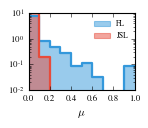

In [83]:
plt.figure(figsize=(3.42/2, 1.2), frameon=False)

# FL histogram
v_FL, b_FL = np.histogram(mixing_FL_arr, bins=np.linspace(0, 1, 11), normed=True)
plt.step(b_FL, [v_FL[0]] + list(v_FL), where='pre', color="#3498db", lw=2)
b_FL_step, v_FL_step = get_x_y_steps(b_FL, [v_FL[0]] + list(v_FL), where="pre")
plt.fill_between(b_FL_step, v_FL_step, color="#3498db", alpha=0.5, label="FL")

# JSL histogram
v_JSL, b_JSL = np.histogram(mixing_JSL_arr, bins=np.linspace(0, 1, 11), normed=True)
plt.step(b_JSL, [v_JSL[0]] + list(v_JSL), where='pre', color="#e74c3c", lw=2)
b_JSL_step, v_JSL_step = get_x_y_steps(b_JSL, [v_JSL[0]] + list(v_JSL), where="pre")
plt.fill_between(b_JSL_step, v_JSL_step, color="#e74c3c", alpha=0.5, label="JSL")

plt.xlabel("$\mu$")
plt.yscale("log")

plt.legend(frameon=False)
plt.savefig("figures/mixing_coef_distribution_workplace.pdf")
plt.show()

### Community overlap

In [111]:
communities_JSL_2 = node_communities(layer_commu_pred_JSL_2)
communities_FL_2 = node_communities(layer_commu_pred_FL_2)
communities_AL_2 = node_communities(layer_commu_pred_AL_2)
communities_NL_2 = node_communities(layer_commu_pred_NL_2)

In [112]:
entropy_JSL_2, overlap_JSL_2 = compute_entropy_and_overlap(communities_JSL_2)
entropy_FL_2, overlap_FL_2 = compute_entropy_and_overlap(communities_FL_2)
entropy_AL_2, overlap_AL_2 = compute_entropy_and_overlap(communities_AL_2)
entropy_NL_2, overlap_NL_2 = compute_entropy_and_overlap(communities_NL_2)

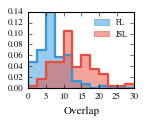

In [160]:
alpha_JSL_2, beta_JSL_2, loc_JSL_2, scale_JSL_2 = sp.stats.beta.fit(overlap_JSL_2)
alpha_FL_2, beta_FL_2, loc_FL_2, scale_FL_2 = sp.stats.beta.fit(overlap_FL_2)

overlap_fit_samples_JSL_2 = sp.stats.beta.rvs(alpha_JSL_2, beta_JSL_2, loc_JSL_2, scale_JSL_2, size=10000)
overlap_fit_samples_FL_2 = sp.stats.beta.rvs(alpha_FL_2, beta_FL_2, loc_FL_2, scale_FL_2, size=10000)


plt.figure(figsize=(3.42/2, 1.2), frameon=False)

# FL histogram
v_FL, b_FL = np.histogram(overlap_fit_samples_FL_2, bins=np.linspace(0, 30, 13), normed=True)
plt.step(b_FL, [v_FL[0]] + list(v_FL), where='pre', color="#3498db", lw=2)
b_FL_step, v_FL_step = get_x_y_steps(b_FL, [v_FL[0]] + list(v_FL), where="pre")
plt.fill_between(b_FL_step, v_FL_step, color="#3498db", alpha=0.5, label="FL")

# JSL histogram
v_JSL, b_JSL = np.histogram(overlap_fit_samples_JSL_2, bins=np.linspace(0, 30, 13), normed=True)
plt.step(b_JSL, [v_JSL[0]] + list(v_JSL), where='pre', color="#e74c3c", lw=2)
b_JSL_step, v_JSL_step = get_x_y_steps(b_JSL, [v_JSL[0]] + list(v_JSL), where="pre")
plt.fill_between(b_JSL_step, v_JSL_step, color="#e74c3c", alpha=0.5, label="JSL")

# AL histogram
# v_AL, b_AL = np.histogram(overlap_AL_2, normed=True)
# plt.step(b_AL, [v_AL[0]] + list(v_AL), where='pre', color="#1abc9c", lw=2)
# b_AL_step, v_AL_step = get_x_y_steps(b_AL, [v_AL[0]] + list(v_AL), where="pre")
# plt.fill_between(b_AL_step, v_AL_step, color="#1abc9c", alpha=0.5, label="AL")

# NL histogram
# v_NL, b_NL = np.histogram(overlap_NL_2, normed=True)
# plt.step(b_NL, [v_NL[0]] + list(v_NL), where='pre', color="#f1c40f", lw=2)
# b_NL_step, v_NL_step = get_x_y_steps(b_NL, [v_NL[0]] + list(v_NL), where="pre")
# plt.fill_between(b_NL_step, v_NL_step, color="#f1c40f", alpha=0.5, label="NL")

plt.xlabel("overlap".capitalize())

plt.legend(frameon=False)
#plt.savefig("figures/overlap_distribution_workplace.pdf")
plt.show()

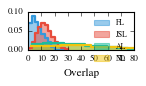

In [242]:
alpha_JSL_2, beta_JSL_2, loc_JSL_2, scale_JSL_2 = sp.stats.beta.fit(overlap_JSL_2)
alpha_FL_2, beta_FL_2, loc_FL_2, scale_FL_2 = sp.stats.beta.fit(overlap_FL_2)
alpha_AL_2, beta_AL_2, loc_AL_2, scale_AL_2 = sp.stats.beta.fit(overlap_AL_2)
alpha_NL_2, beta_NL_2, loc_NL_2, scale_NL_2 = sp.stats.beta.fit(overlap_NL_2)

overlap_fit_samples_JSL_2 = sp.stats.beta.rvs(alpha_JSL_2, beta_JSL_2, loc_JSL_2, scale_JSL_2, size=10000)
overlap_fit_samples_FL_2 = sp.stats.beta.rvs(alpha_FL_2, beta_FL_2, loc_FL_2, scale_FL_2, size=10000)
overlap_fit_samples_AL_2 = sp.stats.beta.rvs(alpha_AL_2, beta_AL_2, loc_AL_2, scale_AL_2, size=10000)
overlap_fit_samples_NL_2 = sp.stats.beta.rvs(alpha_NL_2, beta_NL_2, loc_NL_2, scale_NL_2, size=10000)

plt.figure(figsize=(3.42/2, 2.4/4), frameon=False)

# FL histogram
v_FL, b_FL = np.histogram(overlap_fit_samples_FL_2, bins=np.linspace(0, 30, 13), normed=True)
plt.step(b_FL, [v_FL[0]] + list(v_FL), where='pre', color="#3498db", lw=2)
b_FL_step, v_FL_step = get_x_y_steps(b_FL, [v_FL[0]] + list(v_FL), where="pre")
plt.fill_between(b_FL_step, v_FL_step, color="#3498db", alpha=0.5, label="FL")

# JSL histogram
v_JSL, b_JSL = np.histogram(overlap_fit_samples_JSL_2, bins=np.linspace(0, 30, 13), normed=True)
plt.step(b_JSL, [v_JSL[0]] + list(v_JSL), where='pre', color="#e74c3c", lw=2)
b_JSL_step, v_JSL_step = get_x_y_steps(b_JSL, [v_JSL[0]] + list(v_JSL), where="pre")
plt.fill_between(b_JSL_step, v_JSL_step, color="#e74c3c", alpha=0.5, label="JSL")

# AL histogram
v_AL, b_AL = np.histogram(overlap_fit_samples_AL_2, normed=True)#, bins=np.logspace(0, np.log10(200), 15))
plt.step(b_AL, [v_AL[0]] + list(v_AL), where='pre', color="#1abc9c", lw=2)
b_AL_step, v_AL_step = get_x_y_steps(b_AL, [v_AL[0]] + list(v_AL), where="pre")
plt.fill_between(b_AL_step, v_AL_step, color="#1abc9c", alpha=0.5, label="AL")

# # NL histogram
v_NL, b_NL = np.histogram(overlap_fit_samples_NL_2, normed=True)
plt.step(b_NL, [v_NL[0]] + list(v_NL), where='pre', color="#f1c40f", lw=2)
b_NL_step, v_NL_step = get_x_y_steps(b_NL, [v_NL[0]] + list(v_NL), where="pre")
plt.fill_between(b_NL_step, v_NL_step, color="#f1c40f", alpha=0.5, label="NL")

plt.yticks([0, 0.05, 0.1])
plt.xlabel("overlap".capitalize())
plt.xlim(0, 80)

plt.legend(frameon=False)
plt.savefig("figures/overlap_distribution_workplace_all_distr_beta_fit_wide.pdf")
plt.show()

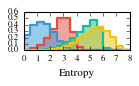

In [237]:
alpha_JSL_2, beta_JSL_2, loc_JSL_2, scale_JSL_2 = sp.stats.beta.fit(entropy_JSL_2)
alpha_FL_2, beta_FL_2, loc_FL_2, scale_FL_2 = sp.stats.beta.fit(entropy_FL_2)
alpha_AL_2, beta_AL_2, loc_AL_2, scale_AL_2 = sp.stats.beta.fit(entropy_AL_2)
alpha_NL_2, beta_NL_2, loc_NL_2, scale_NL_2 = sp.stats.beta.fit(entropy_NL_2)

entropy_fit_samples_JSL_2 = sp.stats.beta.rvs(alpha_JSL_2, beta_JSL_2, loc_JSL_2, scale_JSL_2, size=10000)
entropy_fit_samples_FL_2 = sp.stats.beta.rvs(alpha_FL_2, beta_FL_2, loc_FL_2, scale_FL_2, size=10000)
entropy_fit_samples_AL_2 = sp.stats.beta.rvs(alpha_AL_2, beta_AL_2, loc_AL_2, scale_AL_2, size=10000)
entropy_fit_samples_NL_2 = sp.stats.beta.rvs(alpha_NL_2, beta_NL_2, loc_NL_2, scale_NL_2, size=10000)

plt.figure(figsize=(3.42/2, 2.4/4), frameon=False)

# JSL histogram
v_JSL, b_JSL = np.histogram(entropy_fit_samples_JSL_2, bins=np.linspace(0, 8, 17), normed=True)
plt.step(b_JSL, [v_JSL[0]] + list(v_JSL), where='pre', color="#e74c3c", lw=2)
b_JSL_step, v_JSL_step = get_x_y_steps(b_JSL, [v_JSL[0]] + list(v_JSL), where="pre")
plt.fill_between(b_JSL_step, v_JSL_step, color="#e74c3c", alpha=0.5, label="JSL")

# FL histogram
v_FL, b_FL = np.histogram(entropy_fit_samples_FL_2, bins=np.linspace(0, 8, 17), normed=True)
plt.step(b_FL, [v_FL[0]] + list(v_FL), where='pre', color="#3498db", lw=2)
b_FL_step, v_FL_step = get_x_y_steps(b_FL, [v_FL[0]] + list(v_FL), where="pre")
plt.fill_between(b_FL_step, v_FL_step, color="#3498db", alpha=0.5, label="FL")

# AL histogram
v_AL, b_AL = np.histogram(entropy_fit_samples_AL_2, bins=np.linspace(0, 8, 17), normed=True)
plt.step(b_AL, [v_AL[0]] + list(v_AL), where='pre', color="#1abc9c", lw=2)
b_AL_step, v_AL_step = get_x_y_steps(b_AL, [v_AL[0]] + list(v_AL), where="pre")
plt.fill_between(b_AL_step, v_AL_step, color="#1abc9c", alpha=0.5, label="AL")

# NL histogram
v_NL, b_NL = np.histogram(entropy_fit_samples_NL_2, bins=np.linspace(0, 8, 17), normed=True)
plt.step(b_NL, [v_NL[0]] + list(v_NL), where='pre', color="#f1c40f", lw=2)
b_NL_step, v_NL_step = get_x_y_steps(b_NL, [v_NL[0]] + list(v_NL), where="pre")
plt.fill_between(b_NL_step, v_NL_step, color="#f1c40f", alpha=0.5, label="NL")

plt.xlabel("entropy".capitalize())
plt.xlim(0)

#plt.legend(frameon=False)
plt.savefig("figures/entropy_distribution_workplace_all_distr_beta_fit_wide.pdf")
plt.show()

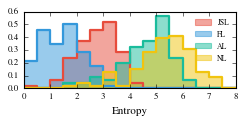

In [228]:
alpha_JSL_2, beta_JSL_2, loc_JSL_2, scale_JSL_2 = sp.stats.beta.fit(entropy_JSL_2)
alpha_FL_2, beta_FL_2, loc_FL_2, scale_FL_2 = sp.stats.beta.fit(entropy_FL_2)
alpha_AL_2, beta_AL_2, loc_AL_2, scale_AL_2 = sp.stats.beta.fit(entropy_AL_2)
alpha_NL_2, beta_NL_2, loc_NL_2, scale_NL_2 = sp.stats.beta.fit(entropy_NL_2)

entropy_fit_samples_JSL_2 = sp.stats.beta.rvs(alpha_JSL_2, beta_JSL_2, loc_JSL_2, scale_JSL_2, size=10000)
entropy_fit_samples_FL_2 = sp.stats.beta.rvs(alpha_FL_2, beta_FL_2, loc_FL_2, scale_FL_2, size=10000)
entropy_fit_samples_AL_2 = sp.stats.beta.rvs(alpha_AL_2, beta_AL_2, loc_AL_2, scale_AL_2, size=10000)
entropy_fit_samples_NL_2 = sp.stats.beta.rvs(alpha_NL_2, beta_NL_2, loc_NL_2, scale_NL_2, size=10000)

plt.figure(figsize=(3.42, 1.2), frameon=False)

# JSL histogram
v_JSL, b_JSL = np.histogram(entropy_JSL_2, bins=np.linspace(0, 8, 17), normed=True)
plt.step(b_JSL, [v_JSL[0]] + list(v_JSL), where='pre', color="#e74c3c", lw=2)
b_JSL_step, v_JSL_step = get_x_y_steps(b_JSL, [v_JSL[0]] + list(v_JSL), where="pre")
plt.fill_between(b_JSL_step, v_JSL_step, color="#e74c3c", alpha=0.5, label="JSL")

# FL histogram
v_FL, b_FL = np.histogram(entropy_FL_2, bins=np.linspace(0, 8, 17), normed=True)
plt.step(b_FL, [v_FL[0]] + list(v_FL), where='pre', color="#3498db", lw=2)
b_FL_step, v_FL_step = get_x_y_steps(b_FL, [v_FL[0]] + list(v_FL), where="pre")
plt.fill_between(b_FL_step, v_FL_step, color="#3498db", alpha=0.5, label="FL")

# AL histogram
v_AL, b_AL = np.histogram(entropy_AL_2, bins=np.linspace(0, 8, 17), normed=True)
plt.step(b_AL, [v_AL[0]] + list(v_AL), where='pre', color="#1abc9c", lw=2)
b_AL_step, v_AL_step = get_x_y_steps(b_AL, [v_AL[0]] + list(v_AL), where="pre")
plt.fill_between(b_AL_step, v_AL_step, color="#1abc9c", alpha=0.5, label="AL")

# NL histogram
v_NL, b_NL = np.histogram(entropy_NL_2, bins=np.linspace(0, 8, 17), normed=True)
plt.step(b_NL, [v_NL[0]] + list(v_NL), where='pre', color="#f1c40f", lw=2)
b_NL_step, v_NL_step = get_x_y_steps(b_NL, [v_NL[0]] + list(v_NL), where="pre")
plt.fill_between(b_NL_step, v_NL_step, color="#f1c40f", alpha=0.5, label="NL")

plt.xlabel("entropy".capitalize())
plt.xlim(0)

plt.legend(frameon=False)
#plt.savefig("figures/entropy_distribution_workplace.pdf")
plt.show()

In [187]:
alpha_JSL_2, beta_JSL_2, loc_JSL_2, scale_JSL_2 = sp.stats.beta.fit(entropy_JSL_2)
alpha_FL_2, beta_FL_2, loc_FL_2, scale_FL_2 = sp.stats.beta.fit(entropy_FL_2)

(array([  3.3186e-04,   1.8252e-03,   7.3010e-03,   2.4558e-02,   6.4050e-02,   1.8667e-01,
          3.7716e-01,   5.3181e-01,   3.9376e-01,   7.1848e-02]),
 array([-1.5799, -0.9772, -0.3746,  0.2281,  0.8307,  1.4334,  2.0361,  2.6387,  3.2414,  3.844 ,
         4.4467]),
 <a list of 10 Patch objects>)

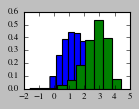

In [190]:
plt.hist(sp.stats.beta.rvs(alpha_FL_2, beta_FL_2, loc_FL_2, scale_FL_2, size=10000), normed=True)
plt.hist(sp.stats.beta.rvs(alpha_JSL_2, beta_JSL_2, loc_JSL_2, scale_JSL_2, size=10000), normed=True)

In [181]:
std

0.73891232199722379